# **Ionic Liquid Modified Electrocatalysts: a STEM-EDX Approach for Identification of Local Distributions within Ionomer Containing Catalysts Layers**

<div align="center">Kai Brunnengräber$^{a}$, Katharina Jeschonek$^{a}$, Michael George$^{a}$, Gui-Rong Zhang$^{a}$, Stefan Lauterbach$^{b}$, Hans-Joachim Kleebe$^{b}$ and Bastian J. M. Etzold$^{a,*}$
    
<div align="center">$^{a}$Technical University of Darmstadt, Department of Chemistry, Ernst-Berl-Institut für Technische und Makromolekulare Chemie, 64287 Darmstadt, Germany
    
<div align="center">$^{b}$Technical University of Darmstadt, Department of Material- and Geosciences, Institut für angewandte Geowissenschaften, 64287 Darmstadt, Germany
    
<div align="center">$^{*}$ Corresponding Author, E-mail: bastian.etzold@tu-darmstadt.de

## **Appendix B: Data Processing Script**

In the corresponding study, STEM-EDS spectral imaging was employed to locate the IL distribution on the catalyst in presence of nafion. To overcome the difficulties associated with necessary low energy STEM-EDS (low count statistics, signal overlap) we setup a sophisticated data processing routine based on machine learning. The provided jupyterlab notebook provides said routine in an easily accessible way.

### Dependencies

List dependencies for runing the full script, including versions

- python (>=3.8)
- numpy
- matplotlib
- scipy
- hyperspy

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import gaussian
from scipy.ndimage.filters import convolve

import hyperspy.api as hs
import hyperspy.components1d as create_component

### Functions and general Parameters

In [43]:
# figure defaults
mpl.rcParams['figure.dpi'] = 300.0
mpl.rcParams['figure.figsize'] = (6.6, 3.3)

In [5]:
def precondition(s, scale=2):
    if (scale % 2) or (scale < 2):
        raise ValueError('"scale" must be even and greater 2')
    fs = s.rebin(scale=(scale // 2, scale // 2, 1))
    k1 = np.array([[[1, 4, 6, 4, 1]]])
    k1 = k1 / k1.sum()
    fs.data = convolve(fs.data, k1, mode='nearest')
    k2 = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]])
    k2 = k2 / k2.sum()
    k2 = k2[:, :, None]
    fs.data = convolve(fs.data, k2, mode='nearest')
    fs = fs.rebin(scale=(2, 2, 2))
    return fs

In [6]:
def add_strobe_component(model, max_offset=0.1, bound_channels=4,
                         centre=None, sigma=None):
    """Add component resembling the detector strobe signal.

    Parameters
    ----------
    model: EDSTEMModel instance

    max_offset: float
        Maximum offset of the strobe centre to 0 in keV. Bounds and
        fitting range are determined based on this value.
    bound_channels: int
        Number of channels right to the strobe centre to be included in
        the fitting range. More channels result in a better fit,
        however, any overlapping signals in that range will cause
        sevier errors.

    Returns
    -------
    strobe: ~hyperspy.model.component1D.Gaussian
    """
    strobe = create_component.Gaussian()
    strobe.name='strobe'
    strobe.isbackground = True
    axis = model.axes_manager.signal_axes[0]
    first_maximum = model.spectrum.isig[None:max_offset].data.argmax()
    if centre is not None:
        strobe.centre.free = False
    else:
        centre = axis.offset + axis.scale * first_maximum
    strobe.centre.value = centre
    strobe.centre.bmin = min(-0.005, max(-max_offset, centre - axis.scale))
    strobe.centre.bmax = max(0.010, min(max_offset, centre + axis.scale))
    if sigma is not None:
        strobe.sigma.free = False
        strobe.sigma.value = sigma
    model.append(strobe)
    model.fit_component(strobe,
                        (axis.offset, centre + axis.scale * bound_channels),
                        fit_independent=True,
                        bounded=True,
                        only_current=False,
                        iterpath='serpentine')
    strobe.centre.free = False  # fix strobe centre
    return strobe

Efficiency curve data for the Oxford Instruments X-Max80 detector used in this study. Data along the full energy range available to the detector with channel widths of 1 eV. This detector features a MOXTEK AP3 window.

In [7]:
dect_E, dect_eff = np.genfromtxt('data/detector_efficiency.csv')
offset = dect_E.min()
scale = dect_E[1] - dect_E[0]

In [8]:
def add_physical_background(model, efficiency=dect_eff,
                            signal_range=None, offset=offset, scale=scale,
                            sigma=None, E0=200.0, cutoff_energy=0.020):
    """
    Function generating a physical background model, assuming Kramer's Law
    for Bremsstrahlung generation. Trys to account for X-Ray absorption and
    transmission inside the eds detector.
    
    Parameters:
    -----------
    model: EDSTEMModel instance
        Hyperspy model instance to which the background component will be added.
    efficiency: array
        EDS-Detector efficiency curve, composed of X-Ray adsorption in the
        detecors window and dead layers as well as accounting for transmission
        of higher energy X-Rays through the active layer of the detector chip.
        Values are assumed to be floats inbetween 0.0 and 1.0, corresponding to
        equally spaced energy channels, defined by 'offset' and 'scale'.
    signal_range: tuple of floats, optional
        Indicates a signal range in keV, inbetween the initial background fit
        is conducted. This range should contain only bremsstrahlung. Default
        None skips the initial fit. Component is fixed after fitting.
    offset: float
        Offset of the energy channels in keV.
    scale: float
        Width of the energy channels in keV.
    sigma: float, optional
        Electronic noise of the detector as sigma of the strobe signal in keV.
        Can also be calculated from the detectors energy resolution given as
        FWHM MnKa. If no value is provided the model is searched for a 'strobe'
        signal, of which the sigma value will be used, otherwise fall back to
        a default value of 0.019 keV. The latter corresponts to an energy
        resolution of 130 eV FWHM MnKa, typicall for current SDD detecotrs.
    E0: float, optional
        Acceleration voltage of the TEM used for the measurement. Defaults to
        200 keV.
    cutoff_energy : float, optional
        Minimum energy below the detector efficiency is 0 in keV.
        Default value is 0.020 keV (hardcoded minimum: 0.001 keV).
    """
    if not sigma:
        try:
            sigma = model['strobe'].sigma.value
        except ValueError:
            sigma = 0.019
    E = np.arange(len(efficiency)) * scale + offset
    
    mask = E > max([0.001, cutoff_energy])
    y = np.ones_like(E)
    y[~mask] = 0
    y[mask] *= efficiency[mask]
    
    # calculate Bremsstrahlung based on Kramer's Law
    # Kramer's Law K coefficient is missing here, but
    # will be resembled by the components yscale parameter
    y[mask] *= (E0 / E[mask] - 1)
    
    # convolve with estimated electronic noise, modeled by a gaussian
    noise = gaussian(int(np.ceil(sigma / scale) // 2 * 6 + 1), sigma / scale)
    noise /= noise.sum()
    y = np.convolve(y, noise, mode='same')
    
    am = dict(name='E', size=len(E), offset=offset, scale=scale, units='keV')
    s1D = hs.signals.EDSTEMSpectrum(y / y.sum(), axes=[am])
    bss = create_component.ScalableFixedPattern(s1D)
    bss.name = 'bremsstrahlung'
    bss.xscale.free = False
    bss.yscale.free = True
    bss.shift.free = False
    bss.isbackground = True
    
    model.append(bss)
    if signal_range is not None:
        model.fit_component(bss,
                            signal_range,
                            fit_independent=True,
                            only_current=False,
                            iterpath='serpentine')
        bss.yscale.free = False
    return bss

### Raw Data Import

Raw data was initially exported from the instrument in the .mpl/.rpl format. The so exported data was then enriched with missing metadata and STEM-Detector image and packaged in hyperspy's private .hspy format for better compression and easier access. The .hspy format is derived as a subset of the common hdf5 specification.

In [3]:
s = hs.load(r'data\map.hspy')

### Preconditioning

In [11]:
lvar = []
s.decomposition(True, output_dimension=30, print_info=False)
lvar.append((0, s.get_explained_variance_ratio()))
for N in [8, 12, 16]:
    fs = precondition(s, scale=N)
    fs.decomposition(True, output_dimension=30, print_info=False)
    lvar.append((N, fs.get_explained_variance_ratio()))
    del fs

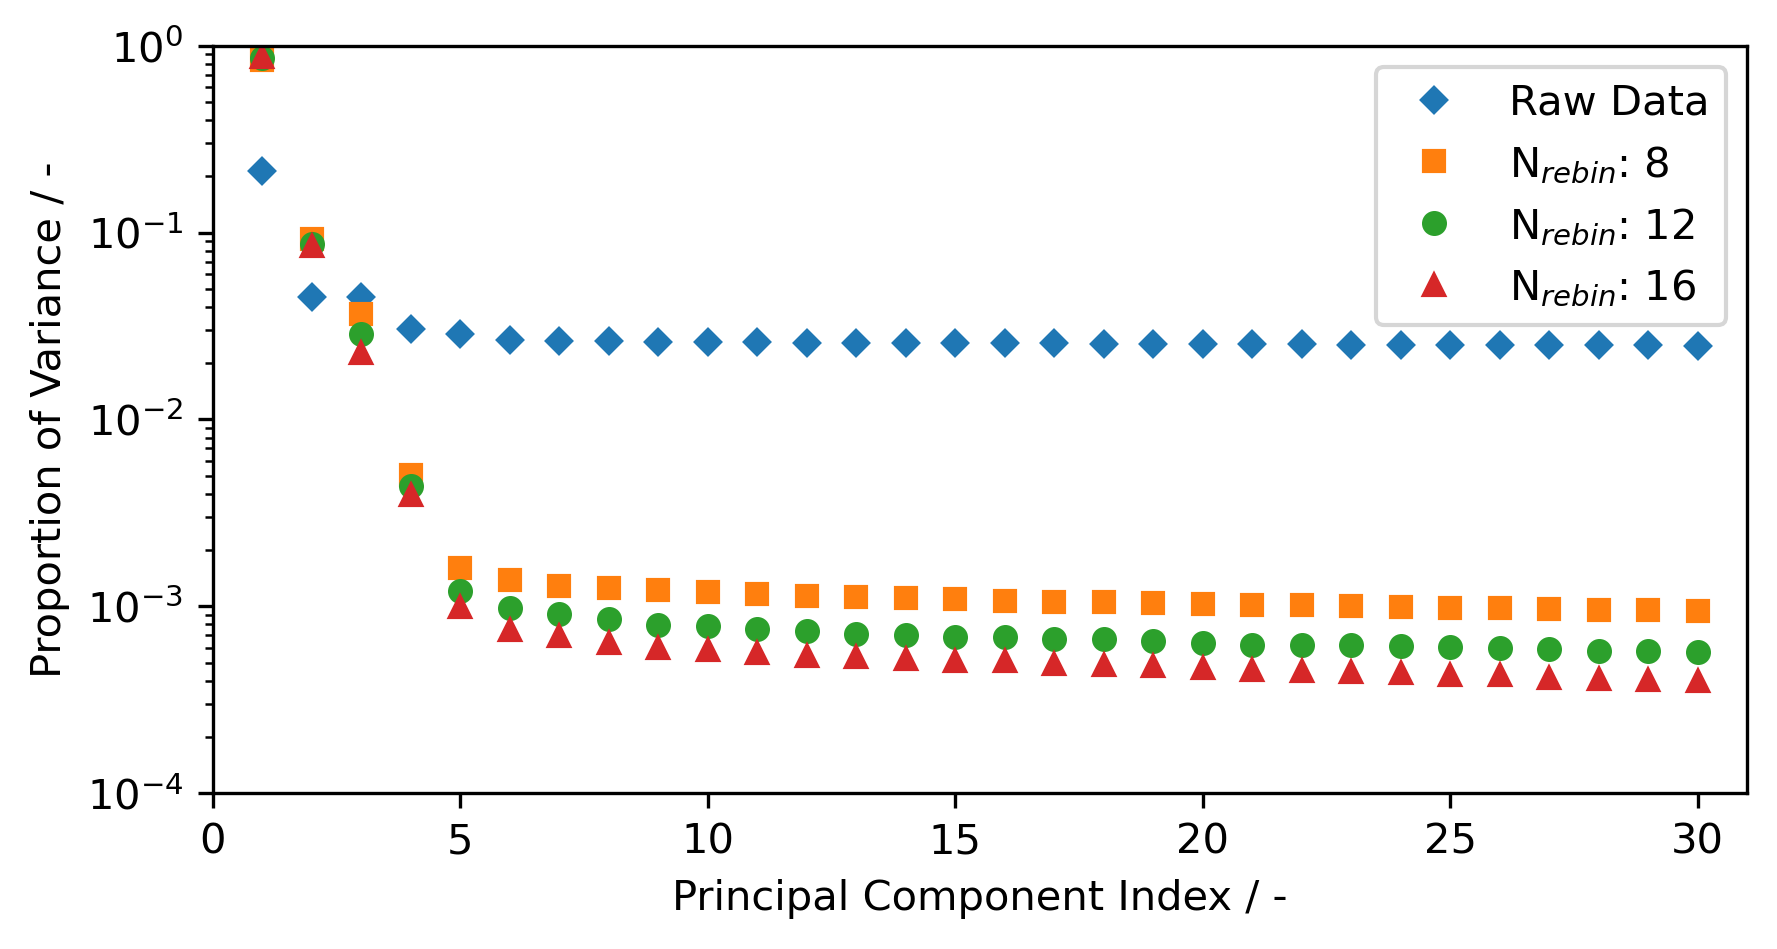

In [44]:
fig, ax = plt.subplots()

ax.set(xlim=(0, 31), ylim=(1e-4, 1e0), yscale='log', 
       xlabel='Principal Component Index / -', ylabel='Proportion of Variance / -')

x = np.arange(1, 31)
markers = ['D', 's', 'o', '^', 'v']
for i, (N, var) in enumerate(lvar):
    label = f'N$_{{rebin}}$: {N:d}' if N > 1 else 'Raw Data'
    ax.plot(x, var.data, ls='none', marker=markers[i],
            ms=5 if markers[i] != 'D' else 4, label=label)
_ = ax.legend(loc='upper right')

Different from the main text and the suggestion by the scree plot above, a rebinning factor of 16 will be choosen for this example script, to speed up the subsequent processing significantly.

In [28]:
N = 16
fit_elements = ['C', 'N', 'O', 'F', 'S', 'Cu', 'Au', 'Si', 'Pt', 'Ni', 'Co', 'Cl']
sys_lines = ['Cr_Ka', 'Cr_Kb', 'Fe_Ka', 'Fe_Kb']

sig = precondition(s, scale=N)
sig.set_elements(fit_elements)

### MVA via NMF

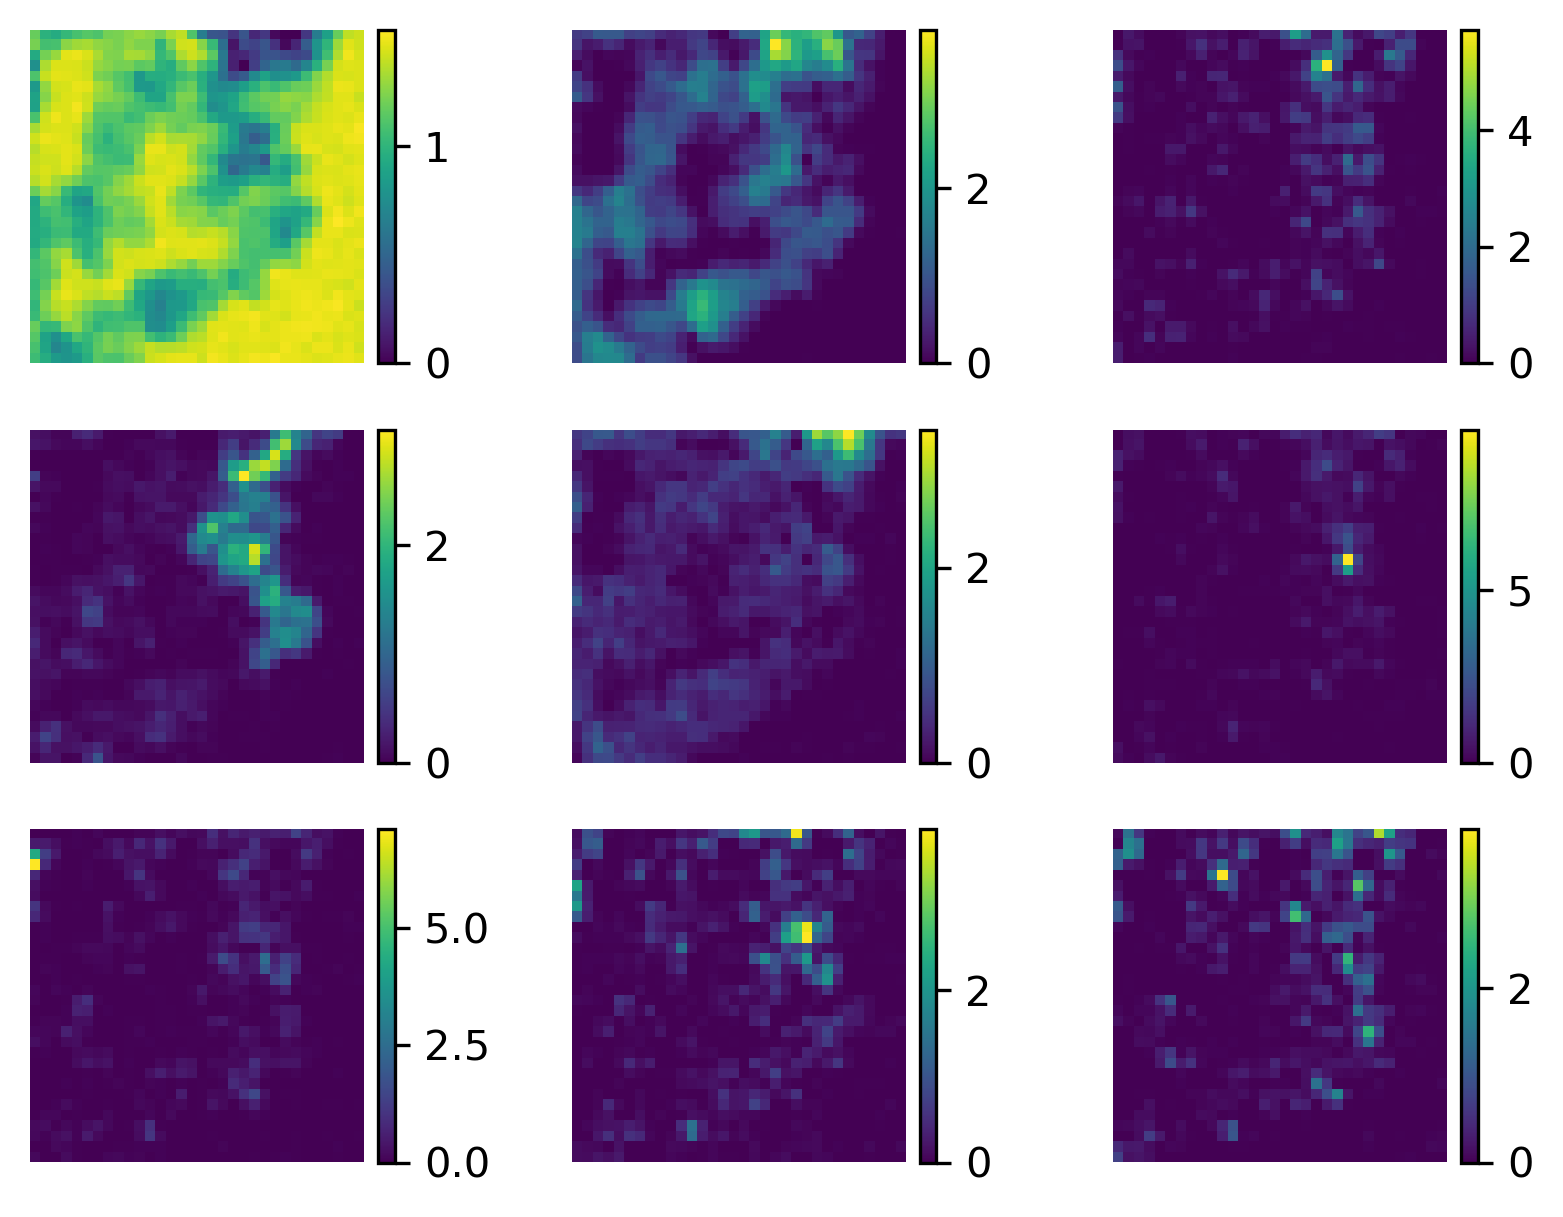

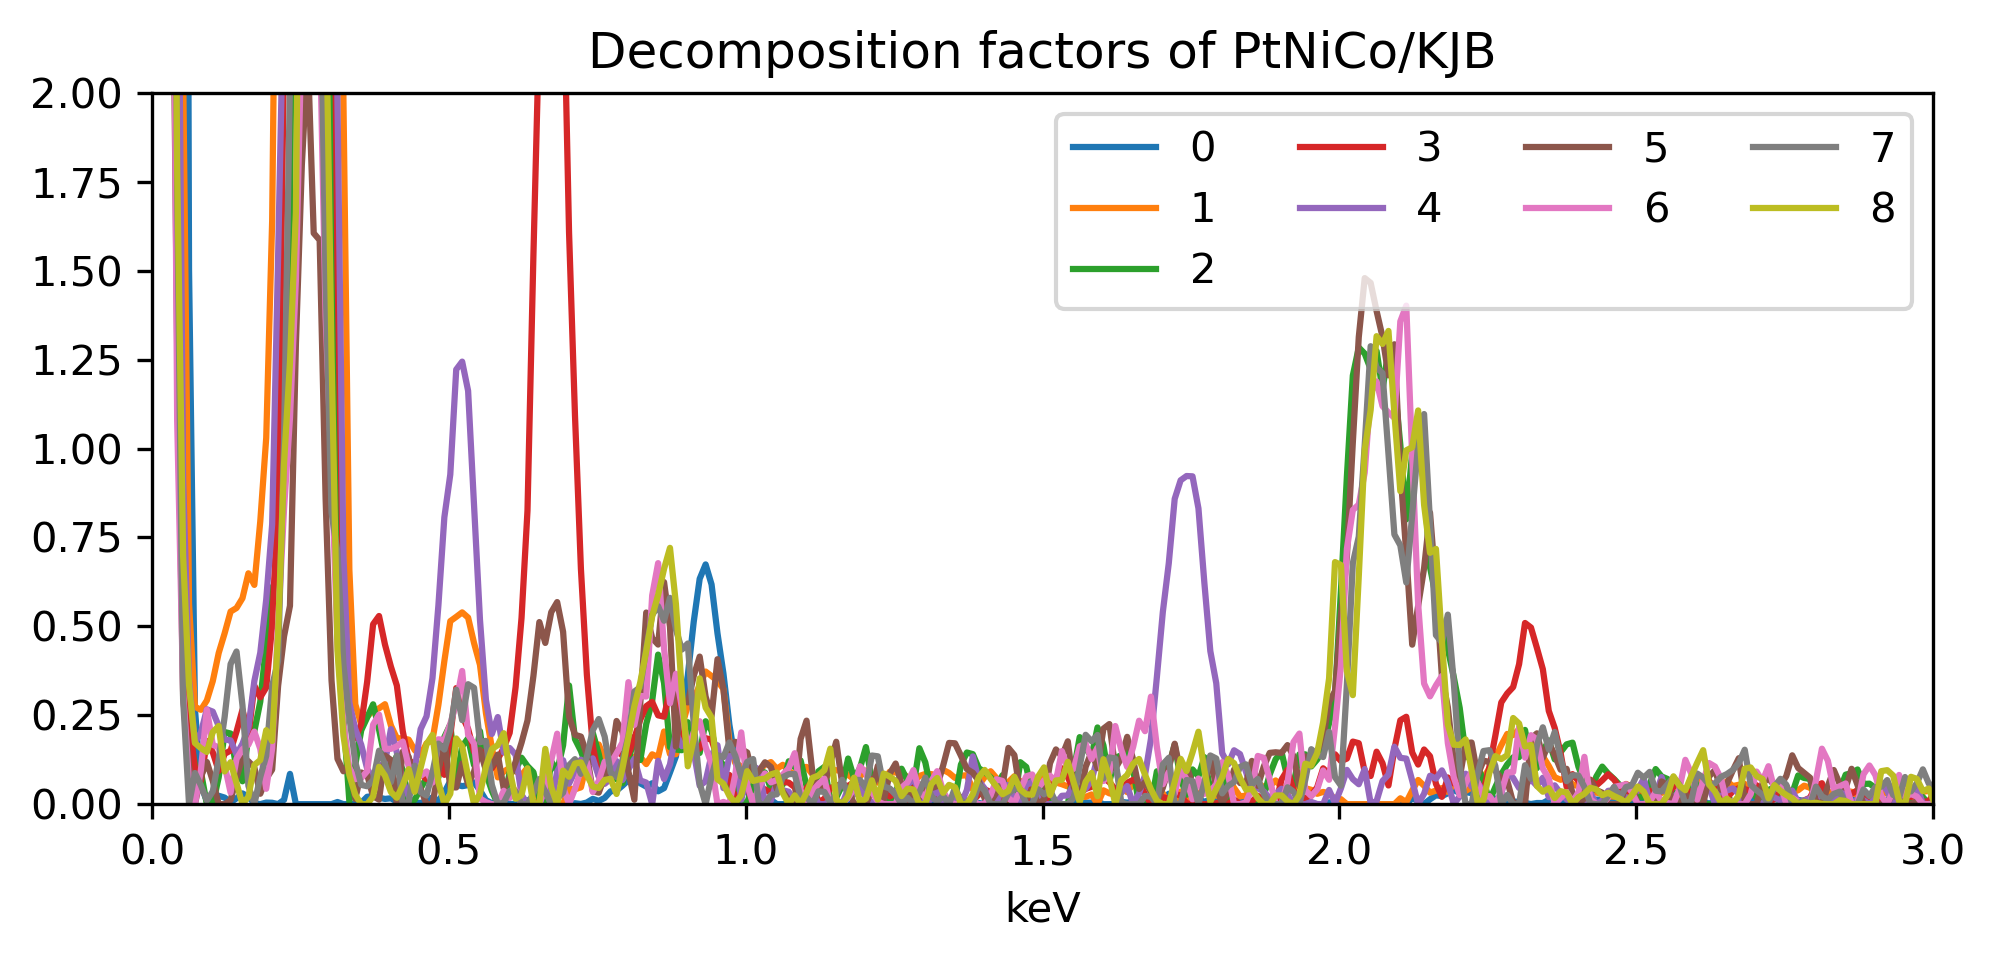

In [45]:
sig.decomposition(normalize_poissonian_noise=True,
                  algorithm='NMF',
                  shuffle=False,
                  alpha=5e-3,
                  tol=4e-4,
                  init='nndsvd',
                  random_state=0,
                  max_iter=1600,
                  output_dimension=9,
                  print_info=False,
                 )

# Decomposition results
comps = sig.get_decomposition_loadings()
_ = hs.plot.plot_images(comps, label = None, cmap='viridis',
                        per_row=3, suptitle='', axes_decor='off')
plt.gcf().set_size_inches(6.6, 5.0)

sig.plot_decomposition_factors()
plt.gca().set(xlim=[0.0, 3.0], ylim=[0.0, 2])

# Elemental Maps and Model Comparision
nmf = sig.get_decomposition_model()

### Model fitting

Fit and refine model parameters in a first step using the sum-spectrum. The main goal is to derive optimized peak centers since low energy section (< 1.4keV) has some significant distortions. These optimized peak positions are then used to initialize a model for the whole dataset, which is then fitted as a second step.

In [37]:
# fitparameters for single-spectrum and full map fits
fitparam = dict(optimizer='lm', bounded=True)

(0.0, 3.0)

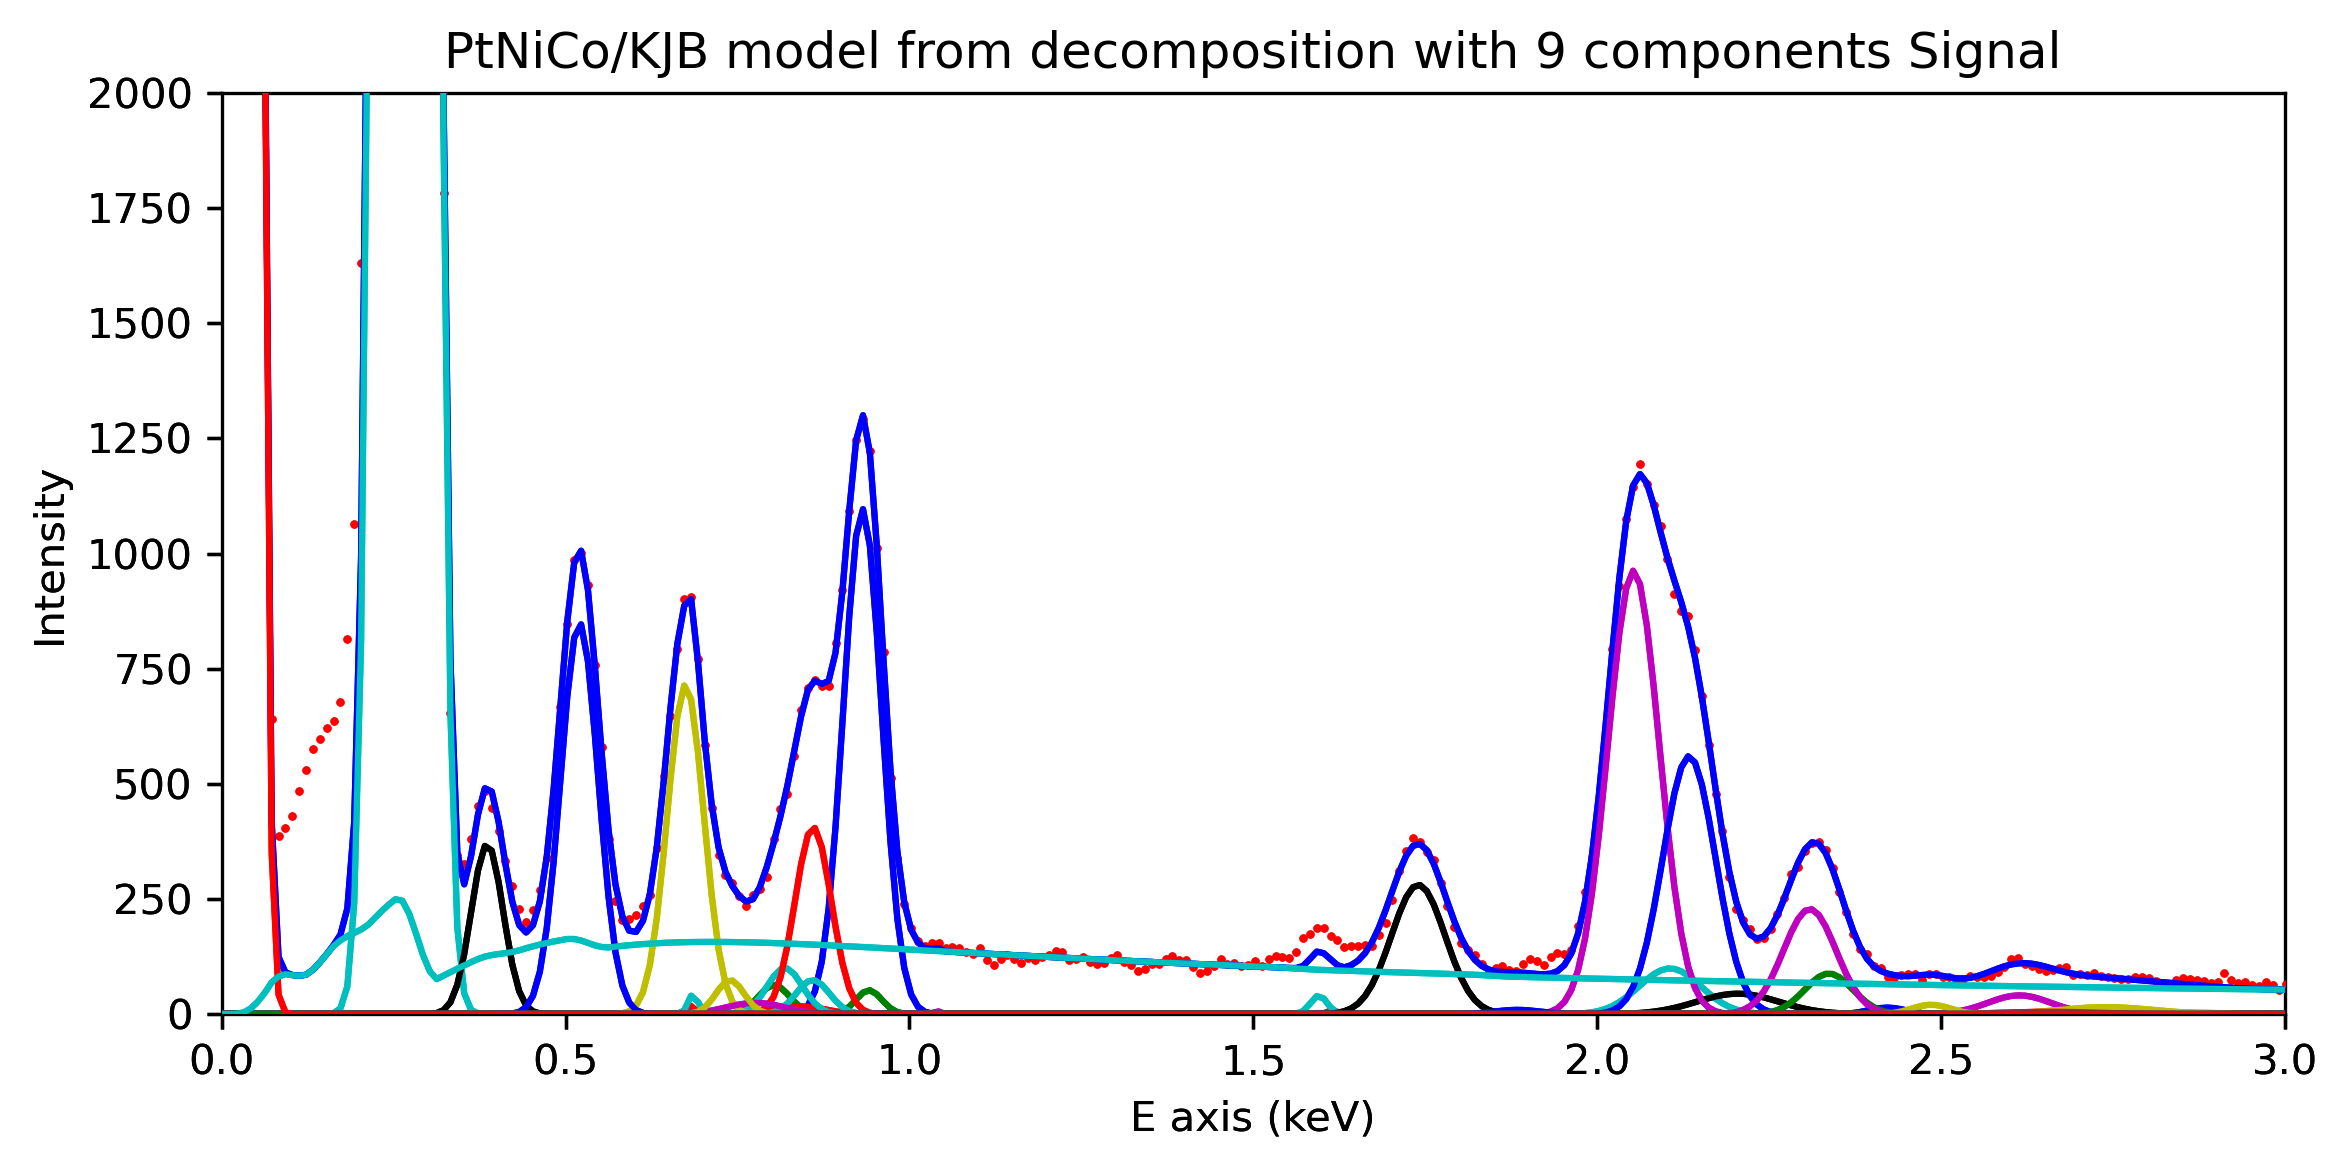

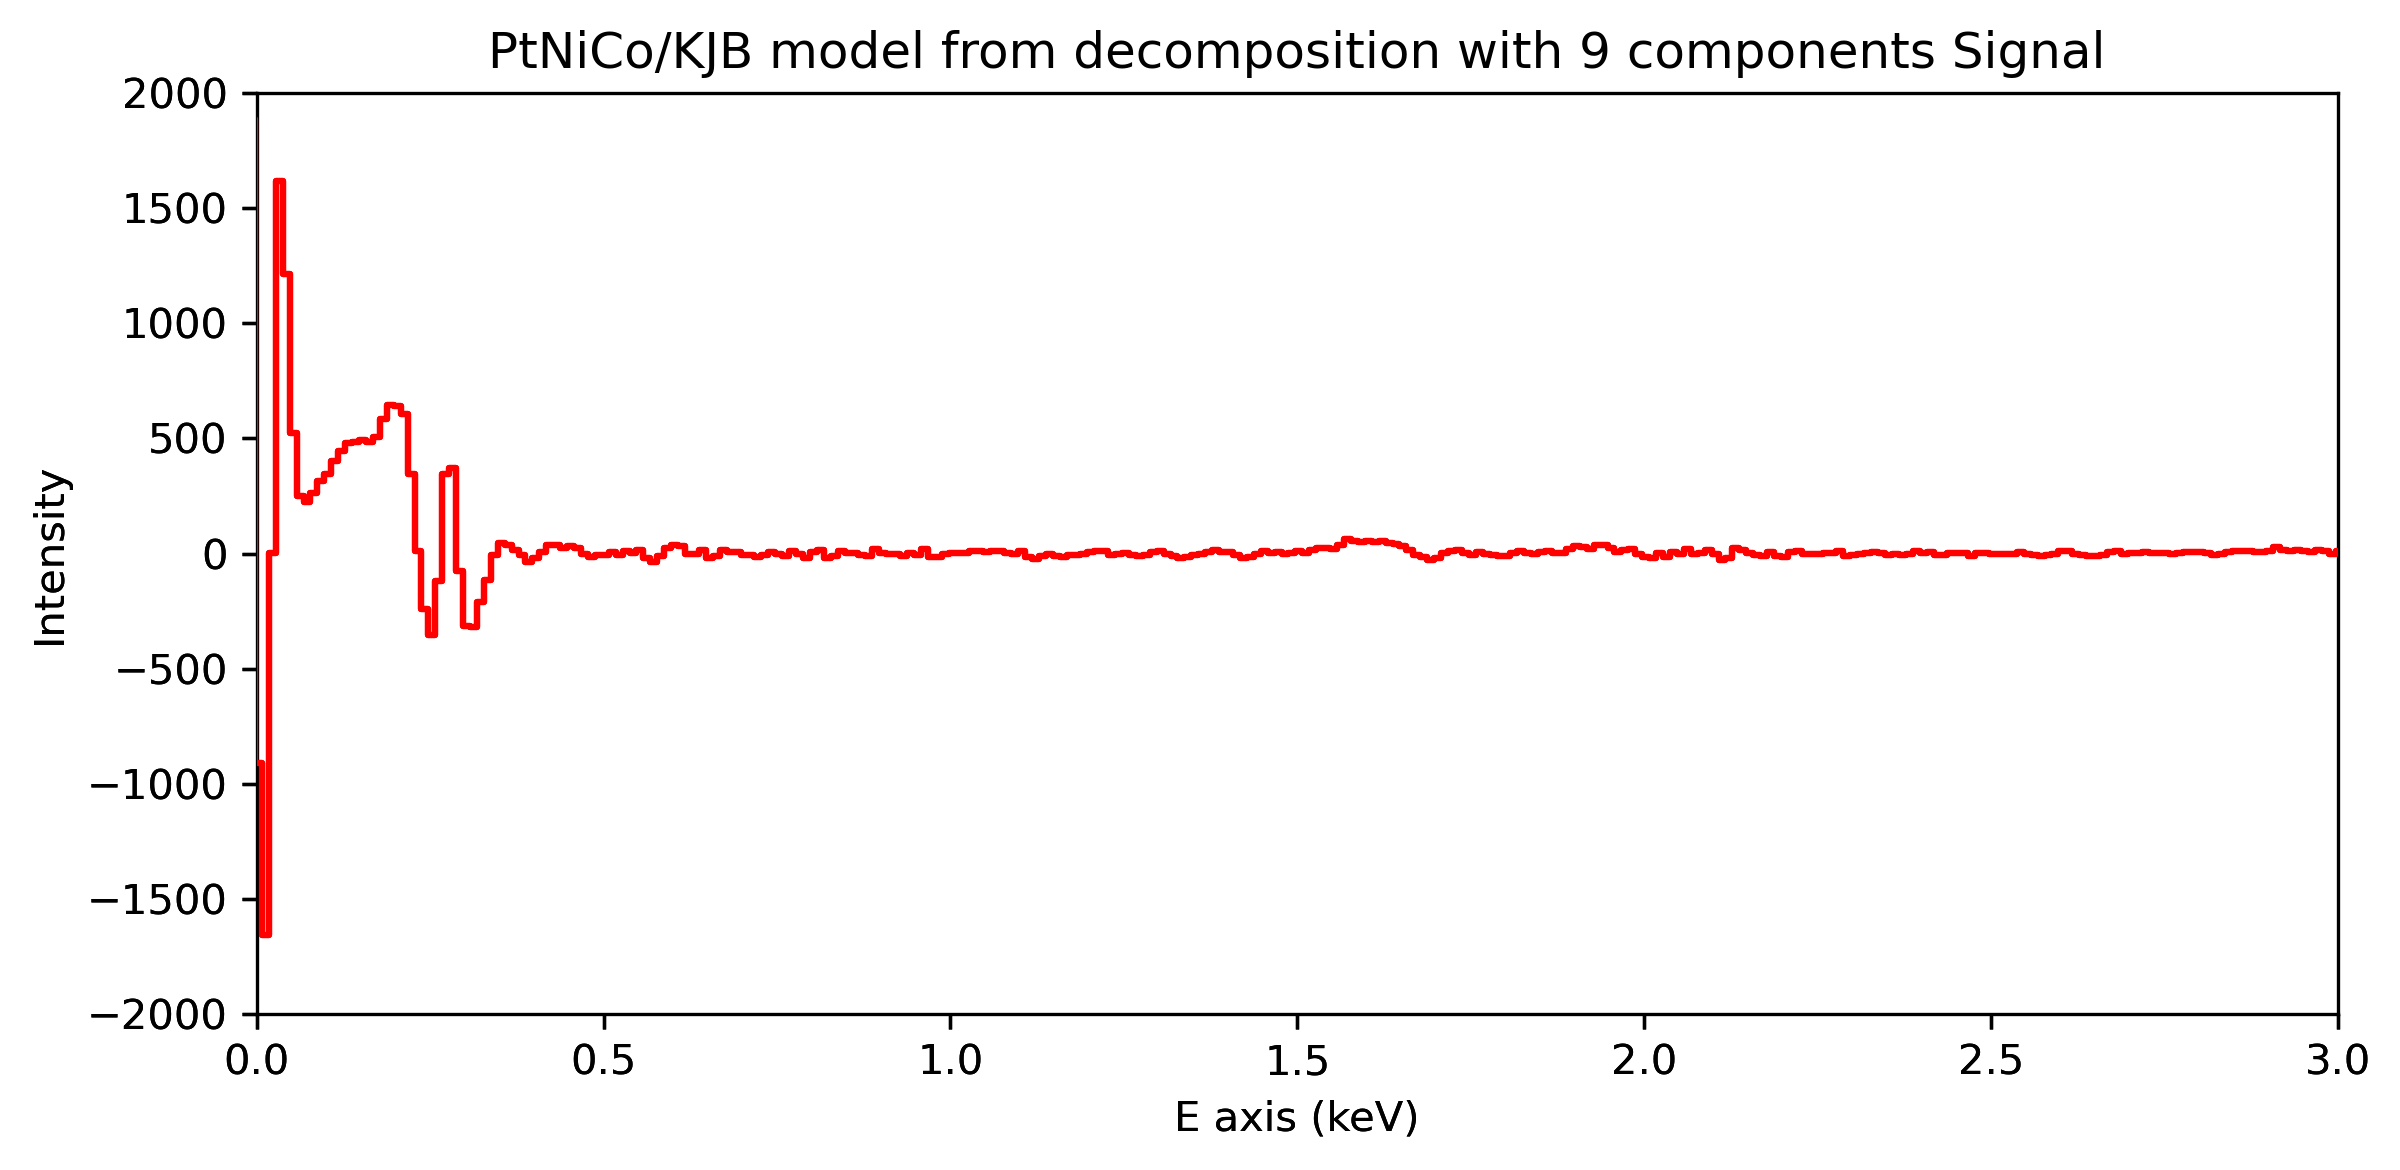

In [39]:
# model initialization
nmf.set_elements(fit_elements)
nmf.estimate_poissonian_noise_variance(gain_factor=1.0, gain_offset=0.1, correlation_factor=1.0)
sum_spc = nmf.sum().deepcopy()
m = sum_spc.create_model(False)

# add typical system lines
m.add_family_lines(sys_lines)

# add strobe and background components
strobe = add_strobe_component(m, bound_channels=8)
bss = add_physical_background(m, signal_range=(1.2, 1.4))

# fitting
m.fit(**fitparam)

# iterative refinement
for i in range(3):
    m.calibrate_xray_lines('energy', bound=15)
    m.calibrate_xray_lines('width', bound=10)
    m.fit(**fitparam)

m.plot(True)
plt.gca().set_ylim(0, 2e3)
plt.gca().set_xlim(0, 3.0)

#plot residuals
(sum_spc-m.as_signal()).plot()
plt.gca().set_ylim(-2e3, 2e3)
plt.gca().set_xlim(0, 3.0)

In [ ]:
# now fit the full spectral image
m2 = nmf.create_model(False)
m2.add_family_lines(sys_lines)

# adjust center values to refined values from sumspectrum fit
for comp in m:
    try:
        try:
            if comp.name != 'strobe':
                m2[comp].centre.value = comp.centre.value
        except KeyError:
            pass
    except Exception:
        pass

# add strobe component, use parameters of previously fitted one
# strobe2 = create_component.Gaussian(name = 'strobe',
#                                     centre=strobe.centre.value,
#                                     sigma=strobe.sigma.value)
# strobe2.centre.free = False
# strobe2.sigma.free = False
# strobe2.A.free = True
# strobe2.isbackground = True
# m2.append(strobe2)

# add strobe
strobe2 = add_strobe_component(m2, centre=strobe.centre.value, sigma=strobe.sigma.value)
strobe2.A.free = False

# add background
bss2 = add_physical_background(m2, signal_range=(1.2, 1.4))
bss2.yscale.free = False

# final, full fit
_ = m2.multifit(iterpath='serpentine', **fitparam)

# save model
m2.store(name='SIfit')
m2.save('map_fitted.hspy')

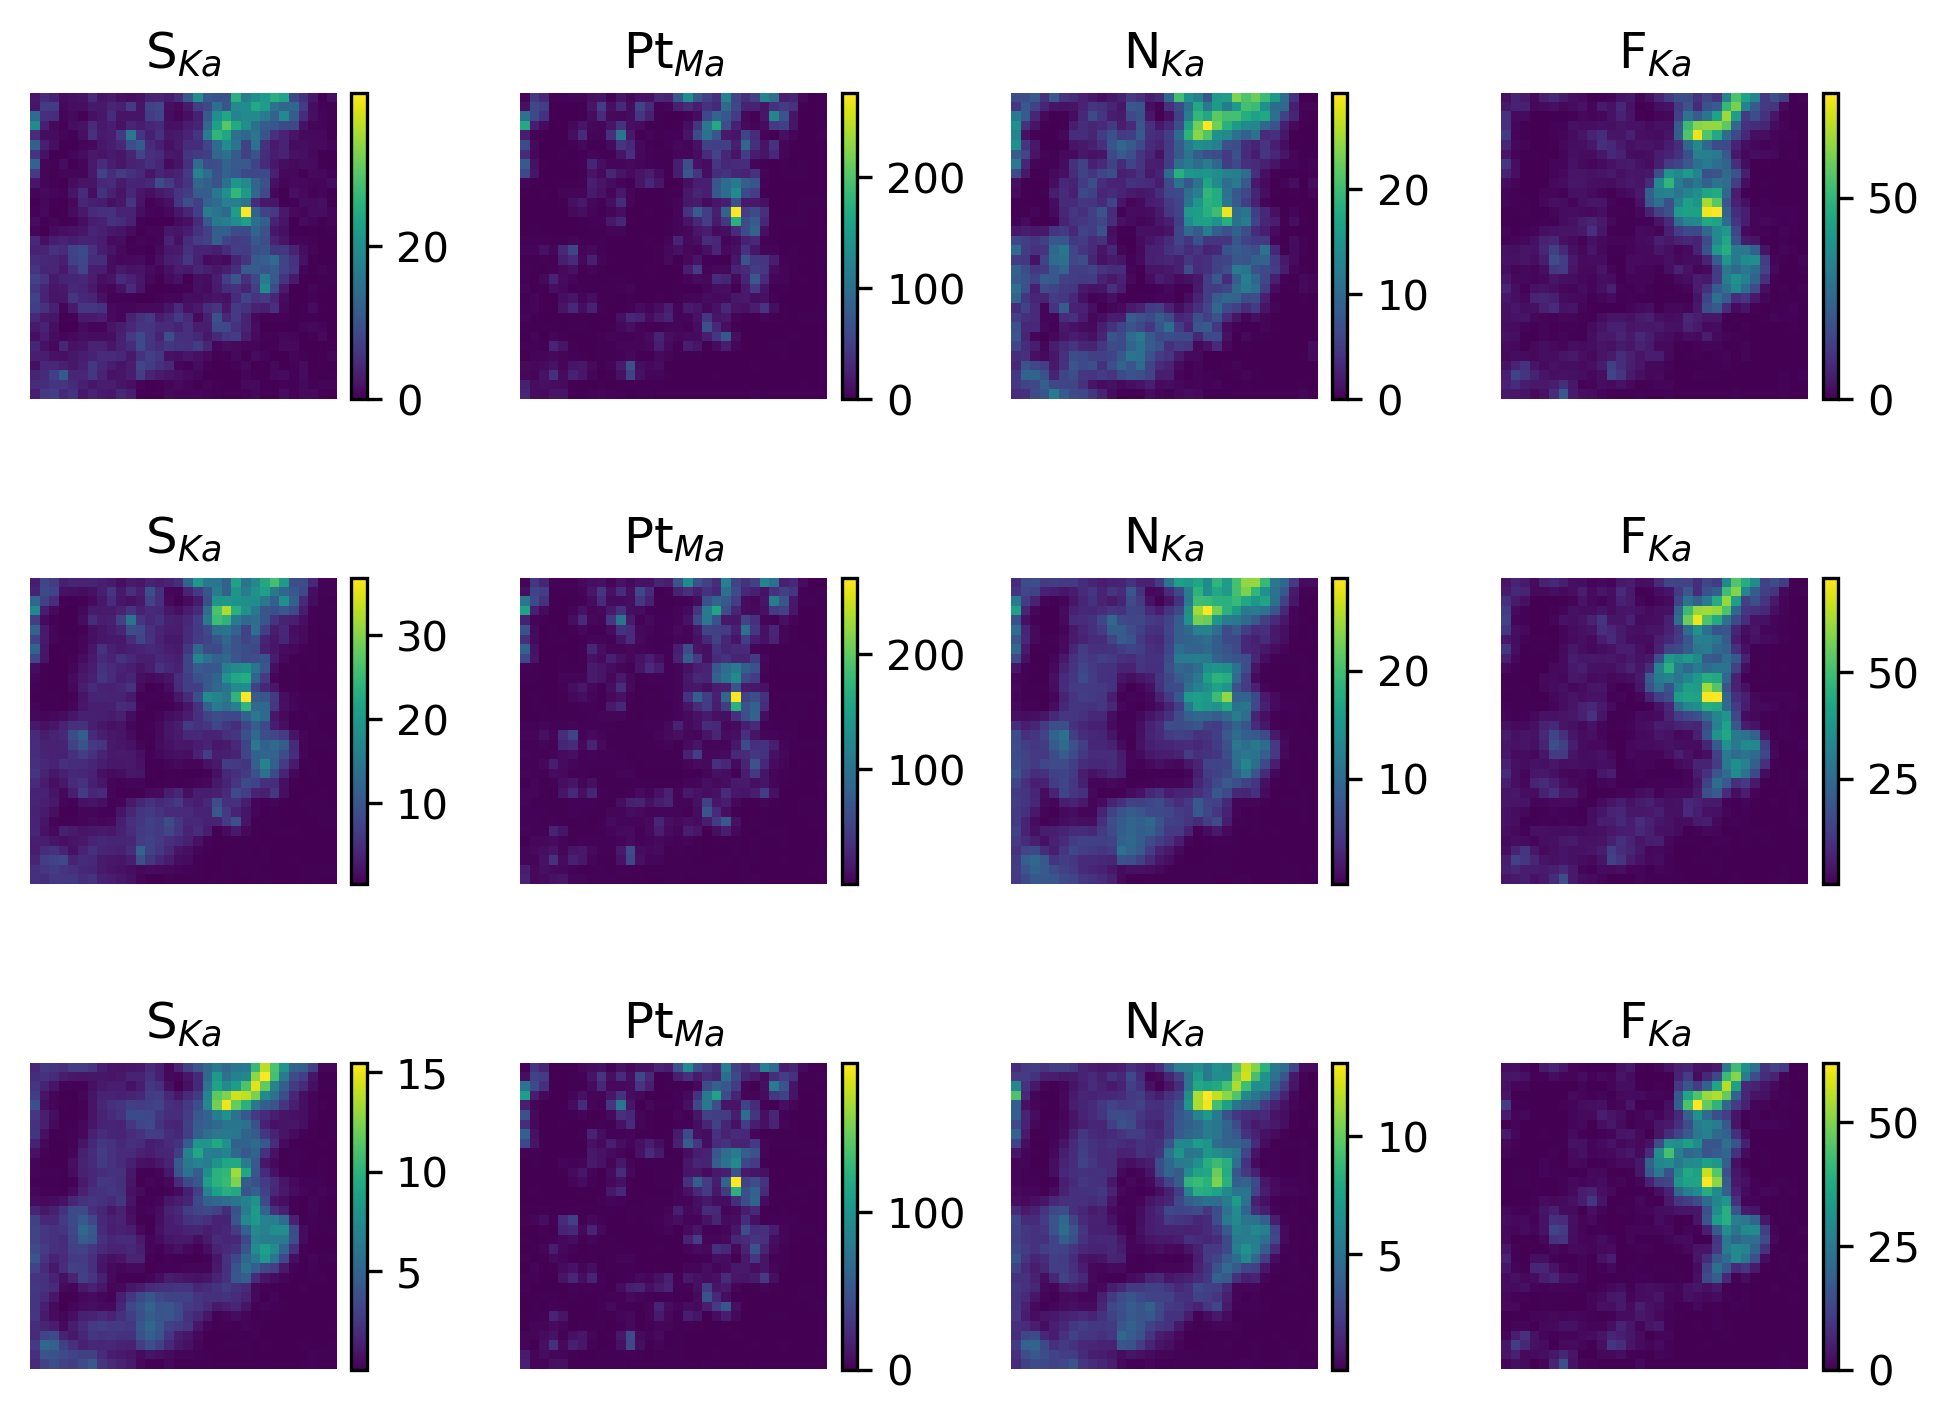

In [50]:
axes = hs.plot.plot_images(sig.get_lines_intensity(['S_Ka', 'Pt_Ma', 'N_Ka', 'F_Ka']) +
                           nmf.get_lines_intensity(['S_Ka', 'Pt_Ma', 'N_Ka', 'F_Ka']) +
                           m2.get_lines_intensity(['S_Ka', 'Pt_Ma', 'N_Ka', 'F_Ka']),
                           per_row=4, axes_decor='off', cmap='viridis',
                           label=['S$_{Ka}$','Pt$_{Ma}$', 'N$_{Ka}$', 'F$_{Ka}$'],
                           )
for ax in axes[1::]:
    ax.get_shared_x_axes().join(axes[0], ax)
    ax.get_shared_y_axes().join(axes[0], ax)
plt.gcf().set_size_inches(6.6, 5.0)
plt.tight_layout()

### Ending Remarks

text text text